**Importing the dataset**

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!ls

kaggle.json  sample_data


In [6]:
!kaggle datasets download -d ruchirrathore/news-dataset

 93% 38.0M/41.0M [00:00<00:00, 66.3MB/s]
100% 41.0M/41.0M [00:00<00:00, 83.4MB/s]


In [7]:
! unzip news-dataset

Archive:  news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


**Importing Libraries**

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize,sent_tokenize
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

In [10]:
print(true.shape)
print(true.info())
true.head()

(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
print(fake.shape)
print(fake.info())
fake.head()

(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [12]:
fake['Label'] = 1
true['Label'] = 0
data = pd.concat([true,fake],axis=0,ignore_index=True)
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [13]:
data.describe()

,Label
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


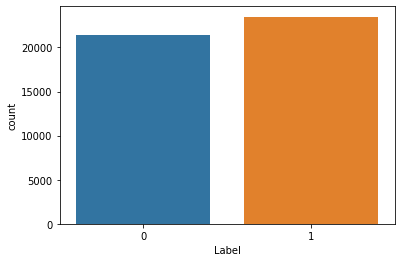

In [14]:
data['text']=data['title']+data['text']
data=data.drop(['title'], axis=1)
sns.countplot(data.Label)

In [15]:
data.isnull().sum()

text       0
subject    0
date       0
Label      0
dtype: int64

In [16]:
data.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

**DATA CLEANING**

In [18]:
nltk.download('stopwords')
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('Reuters','',text)
    return text

data['text'] = data['text'].apply(lambda x:clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
nltk.download('wordnet')
def lemmatize_words(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lem = ' '.join([wnl.lemmatize(word) for word in text.split()])    
    return lem

data['text'] = data['text'].apply(lemmatize_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(data['text'], y,test_size=0.33,random_state=53)

In [23]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)
print(count_train.shape)

(30081, 172625)


**MODEL**

In [24]:
from sklearn.metrics import classification_report

nb_classifier1 = MultinomialNB()
nb_classifier1.fit(count_train, y_train)

pred1 = nb_classifier1.predict(count_test)

print(classification_report(y_test, pred1, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       0.95      0.96      0.95      7178
        True       0.96      0.95      0.96      7639

    accuracy                           0.96     14817
   macro avg       0.95      0.96      0.96     14817
weighted avg       0.96      0.96      0.96     14817



In [25]:
#model 2
nb_classifier2 = MultinomialNB(alpha = 1000)
nb_classifier2.fit(count_train, y_train)

pred2 = nb_classifier2.predict(count_test)

print(classification_report(y_test, pred2, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       0.94      0.92      0.93      7178
        True       0.93      0.95      0.94      7639

    accuracy                           0.94     14817
   macro avg       0.94      0.94      0.94     14817
weighted avg       0.94      0.94      0.94     14817



**Methods for extra accuracy**

Support Vector Machine (SVM)

In [26]:
# 1
from sklearn.svm import SVC

svc_model1 = SVC(C=1, kernel='linear', gamma= 1)
svc_model1.fit(count_train, y_train)

prediction1 = svc_model1.predict(count_test)

print(classification_report(y_test, prediction1, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      7178
        True       0.99      0.99      0.99      7639

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817

